# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [59]:
# импортируем основные библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# читаем файл
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

# первая проверка
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

В ходе первичной проверки данных обнаружено следующее:
- Несмотря на то, что цена 'last_price' в каждом наблюдении округлена до рубля, устанавливать целочисленный тип данных нет необходимости - теоретически цена может быть и с копейками;
- Неверно определен тип данных столбца 'first_day_exposition' - необходимо установить тип datatime;
- Замечены пропуски в столбце 'ceiling_height' - заполним данные медианными значениями;
- Замечены пропуски в столбце 'floors_total' - их не много, предполагаю, что это одноэтажные дома;
- Замечены пропуски в столбце 'living_area' - предполагаю, что часть из пропущенных данных обусловлена присутсвием нежилого типа объектов;
- Замечены пропуски в столбце 'is_apartment' - данный столбец должен иметь тип данных bool, а не object, после обработки пропусков быть не должно;
- Замечены пропуски в столбце 'kitchen_area' - необходимо провести дополнительный анализ на причины появления пропусков;
- Замечены пропуски и неверный тип данных в столбце 'balcony' - пропуски могут быть объяснены отсутствием балконов. Необходимо изменить тип данных с вещественного на целочисленный - в квартире не может быть полтора балкона;
- Замечено незначительное количество пропусков в столбце 'locality_name';
- Наличие пропусков в столбцах 'airports_nearest' и 'cityCenters_nearest' можно обосновать тем, что часть объектов недвижимости располагается за пределами городов, поэтому заполнять пропуски мы не будем;
- Таким же образом объясняются пропуски в столбцах 'parks_around3000', 'ponds_around3000', помимо этого для данных столбцов неверно определен тип данных - по аналогии с балконами, не может быть полтора парка или водоемов - необходимо изменить тип данных на целочисленный;
- Обнаружены пропуски в столбцах 'parks_nearest' и 'ponds_nearest' для тех наблюдений, которые не обладают парками и водоемами в радиусе 3 км. Нет подходящего способа заменить пропущенные данные, так что оставим как есть.
- Также необходимо изменить тип данных с вещественного на целочисленный в столбце 'days_exposition' и определить причину появления пропусков.

### Шаг 2. Предобработка данных

#### В первую очередь необходимо заполнить пропуски и изменить типы данных, где это необходимо

##### Дата размещения объявления, срок размещения

In [60]:
# установим подобающий формат времени
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# заполнять пропуски в столбце 'days_exposition' предполагая, что объявление на текущую дату до сих пор открыто - 
# нецелесообразно - данные могут быть искажены. 

# чтобы заменить тип данных на целочисленный, сначала заменяем пропуски на нули, 
# меняем тип данных, возвращаем пропуски
data['days_exposition'] = data['days_exposition'].fillna(0)
data['days_exposition'] = data['days_exposition'].astype(int)
data['days_exposition'] = data.days_exposition.replace(0, 'NaN')


<h2> Комментарий студента</h2>

Попробовал - выскочила ошибка. Перезапустил все ячейки - ошибка пропала, но на всякий случай вернул, как было :) 
</div>

###### Высота потолков

In [61]:
# проверим столбец с данными о высоте потолков на очевидные выбросы
data[data['ceiling_height'] > 15.0]['ceiling_height'].value_counts()
data[data['ceiling_height'] < 2.0]['ceiling_height'].value_counts()

# посчитаем медианную высоту и заполним пропуски
data['ceiling_height'] = data['ceiling_height'].fillna(round(data['ceiling_height'].median(),2))

##### Количество этажей

In [62]:
# проверяем данные на выбросы
data['floors_total'].value_counts()

# заполняем пропуски единицами
data['floors_total'] = data['floors_total'].fillna(1)

# заменяем тип данных на целочисленный
data['floors_total'] = data['floors_total'].astype(int)


##### Жилая зона, кухня, наличие балконов

In [63]:
# заполним пропуски значений нулями
data['living_area'] = data['living_area'].fillna(0)
data['kitchen_area'] = data['kitchen_area'].fillna(0)
data['balcony'] = data['balcony'].fillna(0)

# изменим тип данных столбца 'balcony' на целочисленный
data['balcony'] = data['balcony'].astype(int)

##### Апартаменты

In [64]:
# первичная проверка 
data['is_apartment'].value_counts()

# заменяем пропуски на False - предполагается, что пропуск значений обусловнен тем, что объект не является апартаментом
data['is_apartment'] = data['is_apartment'].fillna(False)

# проверка 
data['is_apartment'].value_counts()

# изменяем тип данных на логический
data['is_apartment'] = data['is_apartment'].astype(bool)

##### Населенные пункты

In [65]:
# удалим пропуски 
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

# замечены различные написания одних и тех же населенных пунктов, необходимо привести их к единому формату
data['locality_name'] = data.locality_name.str.replace('посёлок|поселок|деревня|городского типа|городской','')

# определим функцию, удаляющую получившиеся пробелы в начале строки
def no_left_space(name):
    return name.lstrip()

# применим функцию к датасету
data['locality_name'] = data['locality_name'].apply(no_left_space)

# определим топ-10 населенных пунктов по объявлениям
data['locality_name'].value_counts().head(10)

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
Пушкин               369
Колпино              338
Парголово            327
Гатчина              307
Выборг               237
Name: locality_name, dtype: int64

##### Количество водоемов и парков в радиусе 3 км

In [66]:
# заполняем пропуски нулями, так как парков и водоедом в радиусе 3км не обнаружено
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

# изменяем тип данных на целочисленный
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)

<h2> Комментарий студента</h2>

Принял во внимание!
</div>

##### Расстояние до центра, аэропорта, ближайших парков и водоемов

Нет подходящего способа замены отсутствующих значений, так как установив нулевые значения в пропусках, мы исказим данные. 

##### Итоговая проверка предобработки данных

In [67]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             23699 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around30

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,0.0,9,False,...,0.0,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121


### Шаг 3. Посчитайте и добавьте в таблицу

In [68]:
# добавим данные о стоимости квадрадного метра недвижимости
data['price_per_1m'] = round(data['last_price'] / data['total_area'],2)

# добавим столбец со стоимостью в миллионах рублей
data['last_price_m'] = round(data['last_price'] / 1000000,2)

# добавим информацию о дне недели, месяце и годе размещения объявления
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

# для наглядности приведем цифровой формат к текстовому виду
def month_name(month):
    if  month == 1:
        return 'Январь'
    if  month == 2:
        return 'Февраль'
    if  month == 3:
        return 'Март'
    if  month == 4:
        return 'Апрель'
    if  month == 5:
        return 'Май'
    if  month == 6:
        return 'Июнь'
    if  month == 7:
        return 'Июль'
    if  month == 8:
        return 'Август'
    if  month == 9:
        return 'Сентябрь'
    if  month == 10:
        return 'Октябрь'
    if  month == 11:
        return 'Ноябрь'
    if  month == 12:
        return 'Декабрь'

def weekday_name(weekday):
    if  weekday == 0:
        return 'Понедельник'
    if  weekday == 1:
        return 'Вторник'
    if  weekday == 2:
        return 'Среда'
    if  weekday == 3:
        return 'Четверг'
    if  weekday == 4:
        return 'Пятница'
    if  weekday == 5:
        return 'Суббота'
    if  weekday == 6:
        return 'Воскресенье'

# применим функции к датасету    
data['month'] = data['month'].apply(month_name)
data['weekday'] = data['weekday'].apply(weekday_name)

# определим функцию, классифицирующую вертикальное расположение объекта недвижимости 
def first_last_middle(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

# применим функцию к датасету
data['floor_type'] = data.apply(first_last_middle, axis=1)

# добавим информацию о соотношении жилой площади и площади кухни к общей площади
def living_to_total(row):
    try: 
        return row['living_area'] / row['total_area']
    except:
        return 0

def kitchen_to_total(row):
    try: 
        return row['kitchen_area'] / row['total_area']
    except:
        return 0

# применим функции к датасету
data['living_to_total'] = data.apply(living_to_total, axis=1)    
data['kitchen_to_total'] = data.apply(kitchen_to_total, axis=1) 

<h2> Комментарий студента</h2>

Взял на заметку!

</div>

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Изучаем параметры прощади, цены, числа комнат, высоты потолков

                   Общая площадь, м2


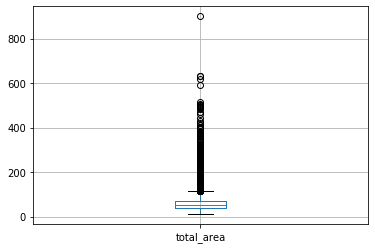

                  Стоимость, млн. руб.


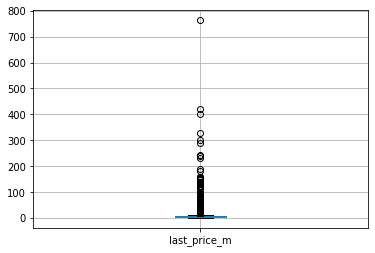

                   Количество комнат


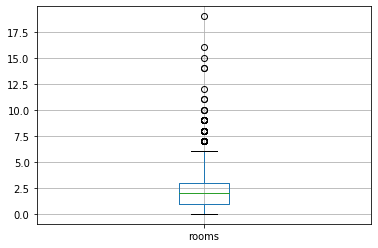

                   Высота потолков, м


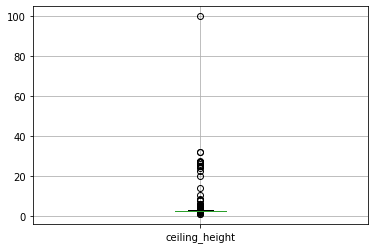

In [69]:
# построим гистограммы распределения изучаемых характеристик
stat_that_matters = [['total_area', '                   Общая площадь, м2'],
                     ['last_price_m', '                  Стоимость, млн. руб.'], 
                     ['rooms', '                   Количество комнат'],
                     ['ceiling_height', '                   Высота потолков, м']
                    ]
for stat in stat_that_matters:
    print(stat[1])
    data.boxplot(column=stat[0])
    plt.show()

<h2> Комментарий студента</h2>

- Полагал, что подписей под графиками будет достаточно, но ошибку понял и исправил :)
- Также автоматизировал построение графиков, тут это уместно
</div>

##### Промежуточный вывод

В ходе анализа основных параметров обнаружено следующее:
- Обнаружены явные выбросы в части данных о высоте потолков: даже в сталинках высота потолков не должна превышать 4 метра, однако сделаем допущение до 6 метров включительно;
- Обнаружены объекты недвижимости с огромной площадью, однако нельзя исключать возможность объединения нескольких квартир;
- Обнаружены объекты недвижимости с очень высокой ценой, необходимо проанализировать стоимость квадратного метра для таких квартир;
- Обнаружены объекты недвижимости с большим количеством комнат - необходимо дополнительно проанализировать среднюю площадь на 1 комнату - значения ниже 10 кв.м должны насторожить;
- Обнаружены объекты с нулевым количеством комнат - возможно, что это опечатка - заменим на 1 комнату.

#### Работа с выбросами

In [70]:
#удалим очевидные выбросы в части высоты потолков
data = data.query('2.0 < ceiling_height <= 6.0')

# заменим опечатки 
data['rooms'] = data['rooms'].replace(0, 1)

# оценим стоимость квадратного метра для поиска выбросов в части цены
data[data['price_per_1m'] > 500000]

# создадим столбец с средней площадью на каждую комнату для поиска прочих выбросов
data['area_per_room'] = data['total_area'] / data['rooms']

# проанализируем выбросы в части количества комнат с помощью средней площади
data[data['area_per_room'] < 15]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,price_per_1m,last_price_m,weekday,month,year,floor_type,living_to_total,kitchen_to_total,area_per_room
377,10,4110000.0,41.0,2018-02-01,3,2.50,5,28.4,2,False,...,15,100243.90,4.11,Четверг,Февраль,2018,другой,0.692683,0.129268,13.666667
407,14,2750000.0,41.5,2017-10-04,3,2.65,5,29.6,5,False,...,28,66265.06,2.75,Среда,Октябрь,2017,последний,0.713253,0.127711,13.833333
516,20,4150000.0,41.3,2018-09-21,3,2.50,5,30.8,5,False,...,20,100484.26,4.15,Пятница,Сентябрь,2018,последний,0.745763,0.133172,13.766667
542,8,1750000.0,40.0,2016-04-28,5,2.65,5,28.6,1,False,...,127,43750.00,1.75,Четверг,Апрель,2016,первый,0.715000,0.125000,8.000000
1456,0,3800000.0,42.1,2018-09-21,3,2.50,5,30.0,3,False,...,56,90261.28,3.80,Пятница,Сентябрь,2018,другой,0.712589,0.125891,14.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23102,0,5800000.0,66.0,2017-06-09,5,2.65,5,55.5,1,False,...,21,87878.79,5.80,Пятница,Июнь,2017,первый,0.840909,0.000000,13.200000
23124,0,3500000.0,41.3,2018-01-11,3,2.55,5,29.5,1,False,...,23,84745.76,3.50,Четверг,Январь,2018,первый,0.714286,0.145278,13.766667
23305,9,4950000.0,67.0,2018-10-29,5,2.60,5,51.2,1,False,...,89,73880.60,4.95,Понедельник,Октябрь,2018,первый,0.764179,0.111940,13.400000
23464,12,4250000.0,48.5,2017-05-05,4,2.65,5,37.3,5,False,...,131,87628.87,4.25,Пятница,Май,2017,последний,0.769072,0.109278,12.125000


##### Результаты поиска и удаления выбросов:
- Выбросы, связанные с некорректной высотой пололков, удалены;
- Опасения по поводу выбросов в части цен и количества комнат также не подтвержены - в выборке всего 36 квартир со стоимостью квадратного метра более 500 тыс. руб., при этом цена за квадратный метр не преодолевает отметки в 2 млн. руб. - такая стоимость вполне реальна для объектов класса "люкс";
- Опасения по поводу количества комнат не подтвержены - в выборке всего 1 объект со средней площадью менее 10 кв.м на комнату.


#### Построение гистограмм для очищенных данных

                   Общая площадь, м2


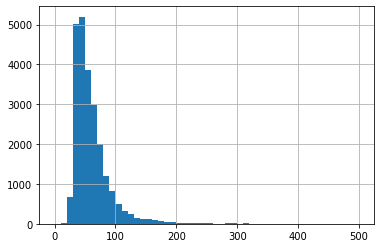

                  Стоимость, млн. руб.


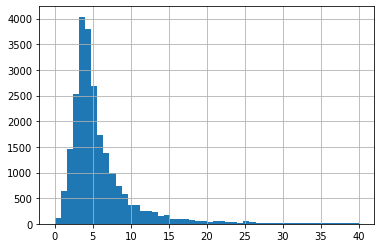

                   Количество комнат


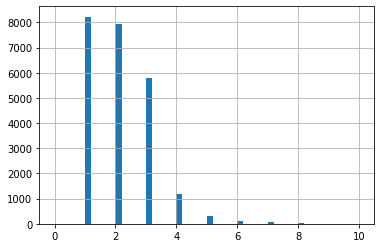

                   Высота потолков, м


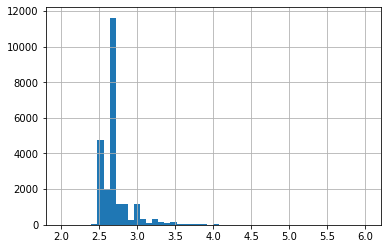

In [71]:
# построим гистограммы распределения изучаемых характеристик
stat_that_matters = [['total_area', '                   Общая площадь, м2', (0, 500)],
                     ['last_price_m', '                  Стоимость, млн. руб.', (0, 40)], 
                     ['rooms', '                   Количество комнат', (0, 10)],
                     ['ceiling_height', '                   Высота потолков, м', (2, 6)]
                    ]
for stat in stat_that_matters:
    print(stat[1])
    data[stat[0]].hist(bins=50, range=stat[2])
    plt.show()

##### По итогам построения гистограмм получены следующие выводы:
- Распределение общей площади, цены и высоты потолков можно приравнять к нормальному;
- Распределение количества комнат больше похоже на пуассоновское;
- Большинство объектов недвижимости имеют площадь от 40 до 60 квадратных метров, стоимость 3.5 - 4.5 млн. руб., 1 или 2 комнаты с высотой потолков около 2.7 метров, что кореллирует с реальным положением на рынке недвижимости Санкт-Петебурга и Ленинградской области.

<h2> Комментарий студента</h2>

Сделано! :) 

</div>

#### Оценка времени продажи квартиры

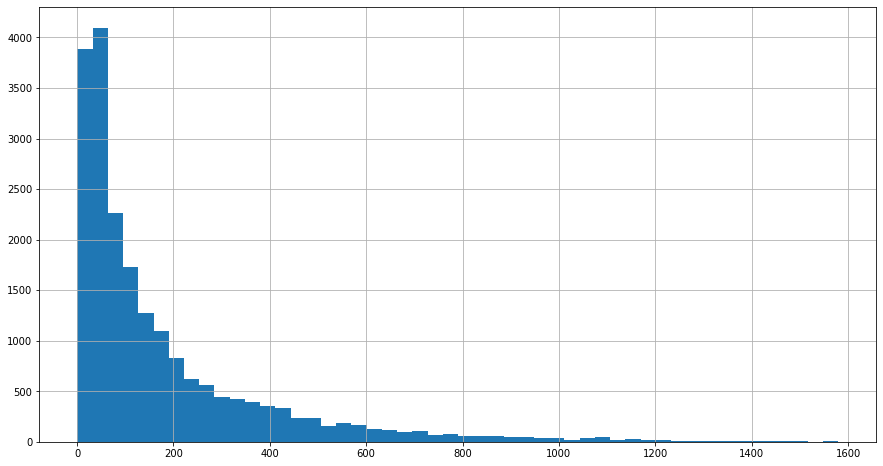

Среднее время продажи недвижимости 180 дней
Медианное время продажи недвижимости 95 дней


In [72]:
# построим гистограмму времени продажи объектов недвижимости
selltime = data[data['days_exposition'] != 'NaN']['days_exposition']
selltime.hist(bins=50, figsize=(15,8))
plt.show()

# посчитаем среднее и медиану
print('Среднее время продажи недвижимости', int(selltime.mean()),'дней')
print('Медианное время продажи недвижимости', int(selltime.median()),'дней')

##### В ходе анализа времени реализации объектов недвижимости получены следующие выводы:
- Среднее и медианное время значительно отличаются - все происходит из-за того, что большинство объектов реализуются в период до 100 дней, однако некоторые объекты могут продаваться и по несколько лет;
- Исходя из медианы можно сделать вывод, что половина всех продаж происходит в срок до 95 дней, а перегиб графика заметен на отметке около 200 дней - это время можно и считать ключевой границей между быстрой и длительной продажей.

#### Оценка влияния различных параметров на стоимость недвижимости

In [73]:
# сделаем срез данных
that_matters = data.loc[:,['last_price_m', 'total_area', 'rooms', 'cityCenters_nearest']]

# рассчитаем корелляцию Пирсона для значимых параметров, выраженных в количественном выражении
print(that_matters.corr())

                     last_price_m  total_area     rooms  cityCenters_nearest
last_price_m             1.000000    0.653748  0.365335            -0.206789
total_area               0.653748    1.000000  0.760247            -0.231586
rooms                    0.365335    0.760247  1.000000            -0.187249
cityCenters_nearest     -0.206789   -0.231586 -0.187249             1.000000


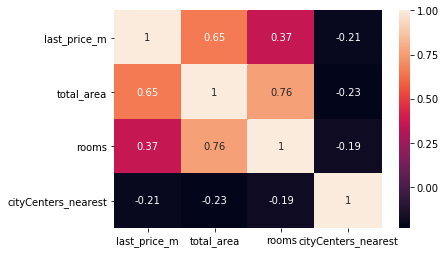

In [74]:
# построим тепловую карту для большей наглядности
sns.heatmap(data=that_matters.corr(), annot=True)

<h2> Комментарий студента</h2>

Сделано!

</div>

In [75]:
# оценим влияние расположения этажа на стоимость
print(data.groupby('floor_type')['last_price_m'].mean())
print()
# оценим влияние даты размещения на стоимость
print(data.groupby('weekday')['last_price_m'].mean())
print()
print(data.groupby('month')['last_price_m'].mean())
print()
print(data.groupby('year')['last_price_m'].mean())

floor_type
другой       6.679418
первый       4.806374
последний    7.365955
Name: last_price_m, dtype: float64

weekday
Воскресенье    6.254071
Вторник        6.396148
Понедельник    6.517094
Пятница        6.376300
Среда          6.630023
Суббота        6.977680
Четверг        6.714249
Name: last_price_m, dtype: float64

month
Август      6.354601
Апрель      6.736664
Декабрь     7.022712
Июль        6.650178
Июнь        6.312588
Май         6.605165
Март        6.365987
Ноябрь      6.463276
Октябрь     6.244307
Сентябрь    6.828216
Февраль     6.472417
Январь      6.667325
Name: last_price_m, dtype: float64

year
2014    12.087153
2015     8.581329
2016     6.828436
2017     6.590490
2018     5.954883
2019     6.784403
Name: last_price_m, dtype: float64


##### В ходе анализа влияния количественных переменных на стоимость недвижимости были получены следующие результаты:
- Наибольшее влияние среди количественных переменных оказывает, очевидно, общая площадь объекта недвижимости - коэффициент корелляции составил 0.65;
- Следующим по влиянию фактором оказалось количество комнат - корелляция составила 0.37. Само по себе влияние количества комнат на окончательную цену не так велико, однако прослеживается цепная зависимость "количество комнат - площадь - стоимость недвижимости", так как количество комнат очень тесно связано с итоговой площадью объекта (коэффициент корелляции 0.76);
- На первый взгляд удаленность от центра отрицательно влияет на итоговую стоимость (корелляция отрицательная), однако такой вывод ошибочен, так как эти факторы имеют обратную зависимость (чем ниже расстояние до центра, тем выше стоимость недвижимости). Однако даже если взять корелляцию по модулю, она составит всего 0.21, что свидетельствует о слабой связи. Более подробный анализ этого фактора будет проведен далее.

##### В ходе анализа влияния категориальных переменных на стоимость недвижимости были получены следующие результаты:
- Квартиры, располагающиеся на первом этаже, в среднем стоят дешевле прочих. В качестве объяснения можно привести тот факт, что в современных домах на первом этаже располагаются коммерческие помещения, соответственно - жилая недвижимость, располагаемая на первых этажах, находится в старых домах, преимущественно хрущевках, что напрямую влияет на её стоимость;
- Квартиры, расположенные на последних этажах, в среднем стоят дороше прочих. В качестве обоснования можно привести факт, что на последних этажах зачастую располагаются пентхаусы, имеющие большую площадь и, соответственно, стоящие дороже остальных;
- День недели и месяц расположения объявления на площадках продаж практически не влияют на стоимость продажи недвижимости, все расхождения можно списать на погрешность;
- Довольно неожиданный момент связан с годом размещения объявления на площадке - средняя стоимость недвижимости, высталенной на продажу в 2014 году, значительно превышает аналогичный показатель за следующие года, при этом в период 2014-2018 гг. средняя стоимость недвижимости продолжала падать. Этот результат можно было бы легко обосновать, если бы стоимость недвижимости измерялась в долларах - в конце 2014 года рубль значительно ослаб, и стоимость недвижимости в долларах значительно просела, однако в данном датасете цены представлены в рублях. Возможно, что после кризиса 2014 года, население предпочитает держать свой капитал в недвижимости, и не продавать её. Либо, наоборот, не обладает достаточным капиталом, чтобы его купить - спрос падает, предложение реагирует на спрос - цены снижаются. 

In [76]:
# определим среднюю стоимость квадратного метра для топ-10 населенных пунктов по количеству объявлений
location_stat = data.pivot_table(index='locality_name', values='price_per_1m', aggfunc=['count','mean'])
location_stat.columns = ['Количество объявлений', 'Средняя цена м2, руб.']
location_stat['Средняя цена м2, руб.'] = round(location_stat['Средняя цена м2, руб.'],2)
print(location_stat.sort_values('Количество объявлений', ascending=False).head(10))

                 Количество объявлений  Средняя цена м2, руб.
locality_name                                                
Санкт-Петербург                  15700              114830.46
Мурино                             588               86064.82
Кудрово                            471               95326.18
Шушары                             440               78677.36
Всеволожск                         397               68719.32
Пушкин                             369              103125.82
Колпино                            338               75424.58
Парголово                          327               90175.91
Гатчина                            306               68757.68
Выборг                             235               58238.14


In [77]:
# определим локацию с наиболее и наименее дорогой стоимостью квадратного метра
print('Наибольшая стоимость квадратного метра в', 
      location_stat[location_stat['Средняя цена м2, руб.'] == location_stat['Средняя цена м2, руб.'].max()].index[0],'-', 
      location_stat['Средняя цена м2, руб.'].max(),'рублей')
print('Наименьная стоимость квадратного метра в', 
      location_stat[location_stat['Средняя цена м2, руб.'] == location_stat['Средняя цена м2, руб.'].min()].index[0],'-', 
      location_stat['Средняя цена м2, руб.'].min(),'рублей')

Наибольшая стоимость квадратного метра в Зеленогорск - 115122.8 рублей
Наименьная стоимость квадратного метра в Старополье - 11206.22 рублей


##### В ходе анализа стоимости квадратного метра в различных населенных пунктах, было выявлено следующее:
- Среди топ-10 населенных пунктов по количеству объявлений лидирует, очевидно, Санкт-Петербург. Вторым по средней стоимости квадратного метра жилья является Пушкин - пожалуй, наиболее престижный город в Ленинградской области;
- Наибольшая средняя цена квадратного метра наблюдается в Зеленогорске - однако это может быть следствием недостаточно полной выборки;
- Наименьшая средняя цена квадратного метра наблюдается в Старополье. 

#### Определение территории, располагающейся в центре Санкт-Петербурга

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

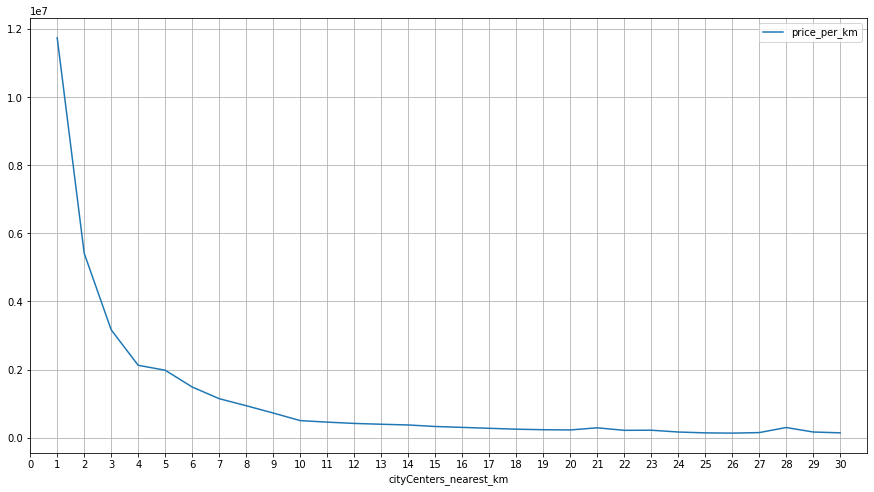

In [78]:
# выберем информацию только по Санкт-Петербургу
spb_stat = data.query('locality_name == "Санкт-Петербург"')

# заполним незначительное количество пропусков медианой
spb_stat['cityCenters_nearest'] = spb_stat['cityCenters_nearest'].fillna(spb_stat['cityCenters_nearest'].median())

# добавим информацию о расстоянии от центра в километрах
spb_stat['cityCenters_nearest_km'] = np.ceil(spb_stat['cityCenters_nearest'] / 1000)

# добавим информацию о стоимости каждого километра
spb_stat['price_per_km'] = round(spb_stat['last_price'] / spb_stat['cityCenters_nearest_km'],0)

# избавимся от нулевых значений
#spb_stat = spb_stat[spb_stat['cityCenters_nearest_km'] != 0]

spb_stat.pivot_table(index='cityCenters_nearest_km', 
                     values='price_per_km', 
                     aggfunc='median').plot(kind='line', figsize=(15,8), 
                                            xticks=[i for i in range(31)], 
                                            xlim=(0,31), grid=True)

#### Вывод:
- Значительный перегиб графика заметен после 4 км от центра - поэтому мы примем эту точку за границу центральной зоны

#### Анализ объектов недвижимости, располагающихся в центре Санкт-Петербурга

                   Общая площадь, м2


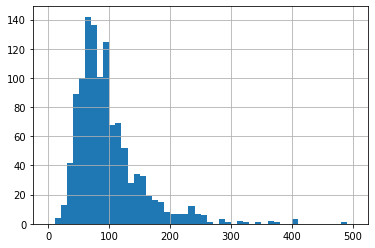

                  Стоимость, млн. руб.


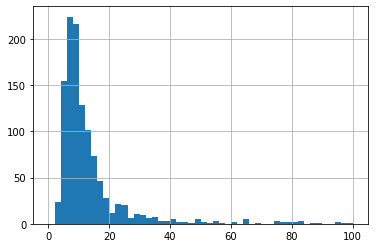

                   Количество комнат


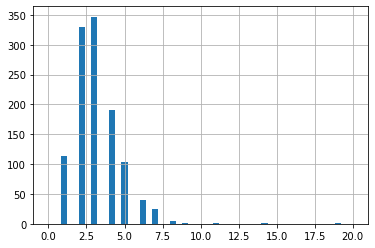

                   Высота потолков, м


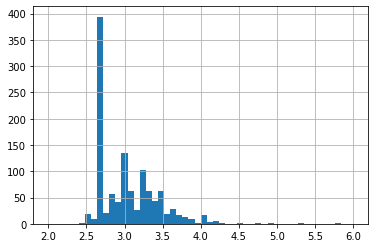

In [79]:
# выделим в отдельную переменную объекты в центре Санкт-Петербурга
royal_data = spb_stat[spb_stat['cityCenters_nearest_km'] <= 4]

# построим гистограммы распределения изучаемых характеристик
stat_that_matters = [['total_area', '                   Общая площадь, м2', (0, 500)],
                     ['last_price_m', '                  Стоимость, млн. руб.', (0, 100)], 
                     ['rooms', '                   Количество комнат', (0, 20)],
                     ['ceiling_height', '                   Высота потолков, м', (2, 6)]
                    ]
for stat in stat_that_matters:
    print(stat[1])
    royal_data[stat[0]].hist(bins=50, range=stat[2])
    plt.show()


<h2> Комментарий студента</h2>

- Абсолютно согласен с вашим мнением насчет необходимости использования автоматизированных методов, однако в данном случае это не так удобно, так как каждая гистограмма обладает различными параметрами `range`
- Тем не менее, решение найдено, построение графиков автоматизировано!
    
</div>

##### По итогам построения гистограмм получены следующие выводы:
- Распределение общей площади и цены, как и в общих данных, можно приравнять к нормальному;
- Распределение количества комнат также стало больше похоже на нормальное;
- Распределение высоты потолков нельзя назвать типичным, оно характеризуется многообразием;
- Большинство объектов недвижимости имеют площадь от 70 до 90 квадратных метров, стоимость 6 - 10 млн. руб., 2 или 3 комнаты с различной высотой потолков;
- Все распределения сдвинулись вправо, что является логическим следствием выборки более престижных объектов недвижимости.

In [80]:
# сделаем срез данных
that_matters_spb = royal_data.loc[:,['last_price_m', 'total_area', 'rooms', 'cityCenters_nearest']]

# рассчитаем корелляцию Пирсона для значимых параметров, выраженных в количественном выражении
that_matters_spb.corr()

,last_price_m,total_area,rooms,cityCenters_nearest
last_price_m,1.000000,0.532031,0.244461,-0.093558
total_area,0.532031,1.000000,0.757255,-0.108078
rooms,0.244461,0.757255,1.000000,-0.049940
cityCenters_nearest,-0.093558,-0.108078,-0.049940,1.000000


In [81]:
# оценим влияние расположения этажа на стоимость
print(royal_data.groupby('floor_type')['last_price_m'].mean())
print()
# оценим влияние даты размещения на стоимость
print(royal_data.groupby('weekday')['last_price_m'].mean())
print()
print(royal_data.groupby('month')['last_price_m'].mean())
print()
print(royal_data.groupby('year')['last_price_m'].mean())

floor_type
другой       16.356621
первый        9.586463
последний    19.110000
Name: last_price_m, dtype: float64

weekday
Воскресенье    15.287313
Вторник        16.088511
Понедельник    14.394706
Пятница        14.035308
Среда          16.015876
Суббота        25.999868
Четверг        15.982869
Name: last_price_m, dtype: float64

month
Август      16.248919
Апрель      17.610783
Декабрь     16.569880
Июль        14.587551
Июнь        13.022235
Май         11.696500
Март        16.272881
Ноябрь      14.167805
Октябрь     13.554787
Сентябрь    21.766832
Февраль     17.071008
Январь      17.836234
Name: last_price_m, dtype: float64

year
2014    34.398889
2015    20.114153
2016    15.832925
2017    16.100935
2018    13.544500
2019    17.638810
Name: last_price_m, dtype: float64


##### В ходе анализа влияния количественных переменных на стоимость недвижимости были получены следующие результаты:
- Наиболее влияющим на стоимость фактором по-прежнему остается площадь объектов недвижимости, однако коэффициент корелляции снизился до 0.53;
- Вторым по значимости количественным фактором осталось количество комнат с коэффициентом корелляции 0.24;
- Расстояние до центра, как и прошлые 2 фактора, стало меньше влиять на стоимость объектов недвижимости;
- Можно сделать вывод, что для жилья в центре города объективные факторы перестают иметь решающее значение, и на первое место выходят субъективные, эмоциональные характеристики. Это же и подтверждает рост многообразия объектов недвижимости.

##### В ходе анализа влияния категориальных переменных на стоимость недвижимости были получены следующие результаты:
- Этажность, как и ранее, оказывает значительное влияние на стоимость недвижимости - наибольшей стоимостью обладают пентхаусы, наименьшей - объекты на первом этаже;
- День недели и месяц выставления объявления оказываюи гораздо большее влияние на цену недвижимости, однако этот факт нельзя обосновать объективными причинами - скорее всего сказывается недостаточный объем выборки, который стал более чем в 20 раз меньше;
- Год подачи объявлений, как и ранее, значительно влияет на стоимость недвижимости, хоть и имеет больший разброс всвязи с малой выборкой.

#### Оценка времени продажи недвижимости в центре Санкт-Петербурга
Проведем небольшое дополнительное исследование, которое подтвердит или опровергнет полученные выводы

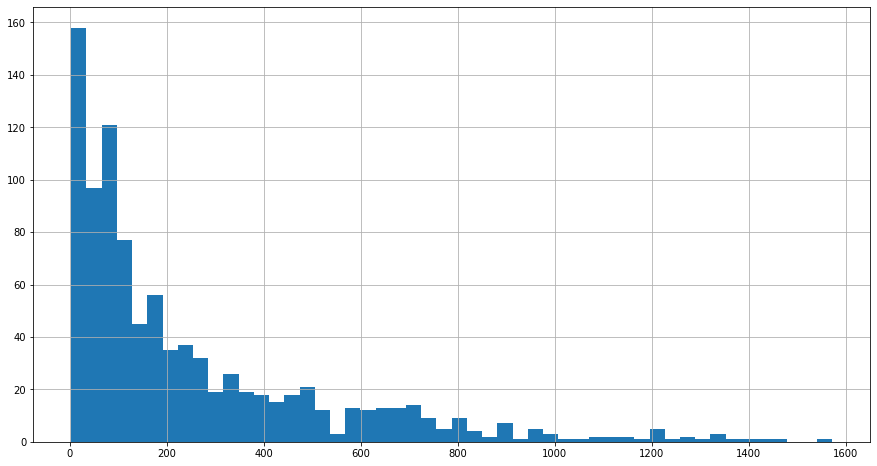

Среднее время продажи недвижимости 254 дней
Медианное время продажи недвижимости 142 дней


In [82]:
# построим гистограмму времени продажи объектов недвижимости в центре Санкт-Петербурга
royal_selltime = royal_data[royal_data['days_exposition'] != 'NaN']['days_exposition']
royal_selltime.hist(bins=50, figsize=(15,8))
plt.show()

# посчитаем среднее и медиану
print('Среднее время продажи недвижимости', int(royal_selltime.mean()),'дней')
print('Медианное время продажи недвижимости', int(royal_selltime.median()),'дней')

#### Выводы:
- И среднее, и медианное время продажи недвижимости стали выше, чем в первично анализируемой выборке;
- Данный результат также свидетельствует об увеличенном многообразии объектов недвижимости, влиянии субъективных факторов как на спрос, так и на предложение.

### Шаг 5. Общий вывод

##### В ходе проведенного анализа получены следующие выводы:
- Для массового сегмента ключевым фактором оценки стоимости недвижимости является площадь помещения, косвенным фактором - количество комнат, больше связанного с площадью, нежели с конечной ценой, а близость к центру оказывает большее влияние, чем на само жилье в центре. В целом полученных выводов достаточно, чтобы с высокой точностью прогнозировать стоимость недвижимости;
- Сегмент более премиального жилья в меньшей степени подвержен влиянию объективных факторов, а также характеризуется большим многообразием. При этом площадь остается хорошим предиктором для определения стоимости, хоть её влияние и снижается. Для большей точности прогнозирования требуется получить больше данных.

#### Какие данные было бы полезно получить в следующий раз:
- Год постройки дома - для определения потенциальных рисков и возможностей;
- Район города - для лучшей апроксимации данных;
- Близость к метро - для дополнительной надбавки или снижения стоимости недвижимости;
- Класс сооружения по информации застройщика (эконом, комфорт, бизнес-класс) - для определения степени потери или прибавки стоимости.

